In [39]:
import sys
!{sys.executable} -m pip -q install openfoamparser

import numpy as np
import openfoamparser as Ofpp
import matplotlib.pyplot as plt

# interpolator
from scipy.interpolate import Rbf

In [46]:
def upper_layer_idxes(points):
    return points[:,2] > 0

def upper_layer(*arrs):
    points = arrs[0]
    if len(arrs) > 1:
        return (arr[upper_layer_idxes(points)] for arr in arrs)
    else:
        return points[upper_layer_idxes(points)]

## Deformation interpolation

In [105]:
def train_interpolator(old_walls, old_obstacle_points, new_obstacle_points, **kwargs):    
    old_obstacle_points, new_obstacle_points = upper_layer(old_obstacle_points, new_obstacle_points)
    old_walls = upper_layer(old_walls)
    
    train_points = np.vstack([old_walls, old_obstacle_points])
    train_values = np.vstack([old_walls, new_obstacle_points])
    
    train_points, uindexes = np.unique(train_points, return_index=True, axis=0)
    train_values = train_values[uindexes]
    
    return (Rbf(*train_points.T, train_values[:,i], **kwargs) for i in range(2))

def interpolate_points(old_points, *interpolators):
    return np.vstack([[intp(*old_points.T) for intp in interpolators], old_points[:,2]]).T

## Extraction of mesh points

In [42]:
mesh_path = '.'
# we load the OpenFOAM mesh
mesh = Ofpp.FoamMesh(mesh_path)

In [49]:
# extract a 3D array which represents the coordinates of the faces which compose the obstacle.
# [0]: faces index
# [1]: point–of-the-face index
# [2]: point coordinate index
def extract_boundary_faces_coords(mesh, key):
    obstacle = mesh.boundary[key]
    obstacle_faces = np.array(mesh.faces[obstacle.start:obstacle.start+obstacle.num])
    obstacle_points = np.apply_along_axis(lambda v: np.array([mesh.points[x] for x in v]), 
                                          axis=1, arr=obstacle_faces)
    return obstacle_points

# extract a 2D array which represents all the points which compose the obstacle
# [0]: point index
# [1]: point coordinate index
def extract_boundary_coords(mesh, key):
    l = []
    for v in extract_boundary_faces_coords(mesh, key):
        l.extend(v)
    return np.array(l)

def walls_coords(mesh):
    keys = [b'inlet', b'outlet', b'top', b'bottom']
    return np.concatenate([extract_boundary_coords(mesh, k) for k in keys])

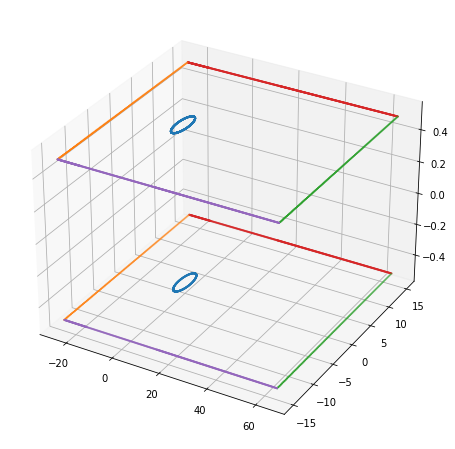

In [50]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(projection='3d')

# obstacle
obstacle = extract_boundary_coords(mesh, b'obstacle')
ax.scatter(*obstacle.T, s=1)

# walls
for k in [b'inlet', b'outlet', b'top', b'bottom']:
    i = extract_boundary_coords(mesh, k)
    ax.scatter(*i.T, s=1)

plt.show()

## Tests
### Test interpolator 1
We consider a simple test with an obstacle on which we apply the transformation $(x,y,z) = (x+1, y+1, z+1)$. Then we evaluate the deformation on 4 points.

In [88]:
def transform(vec):
    return vec + np.array([1,1,0])

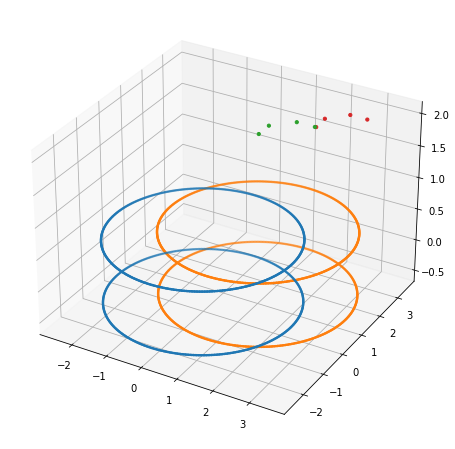

In [111]:
obstacle = extract_boundary_coords(mesh, b'obstacle')

points = np.array([[1,1,2], [2,2,2], [1.5,2,2], [1,1.5,2]])
new_points = interpolate_points(points, *train_interpolator(
                                    walls_coords(mesh), 
                                    obstacle,
                                    np.apply_along_axis(transform, 1, obstacle)
                                )
                            )

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(*obstacle.T, s=2)
ax.scatter(*np.apply_along_axis(transform, 1, obstacle).T, s=2)
ax.scatter(*points.T, s=10, alpha=1)
ax.scatter(*new_points.T, s=10, alpha=1)
plt.show()

### Test interpolator 2
We consider a simple test with an obstacle on which we apply the transformation $(x,y,z) = (x+1, y+1, z+1)$. Then we evaluate the deformation on the mesh.

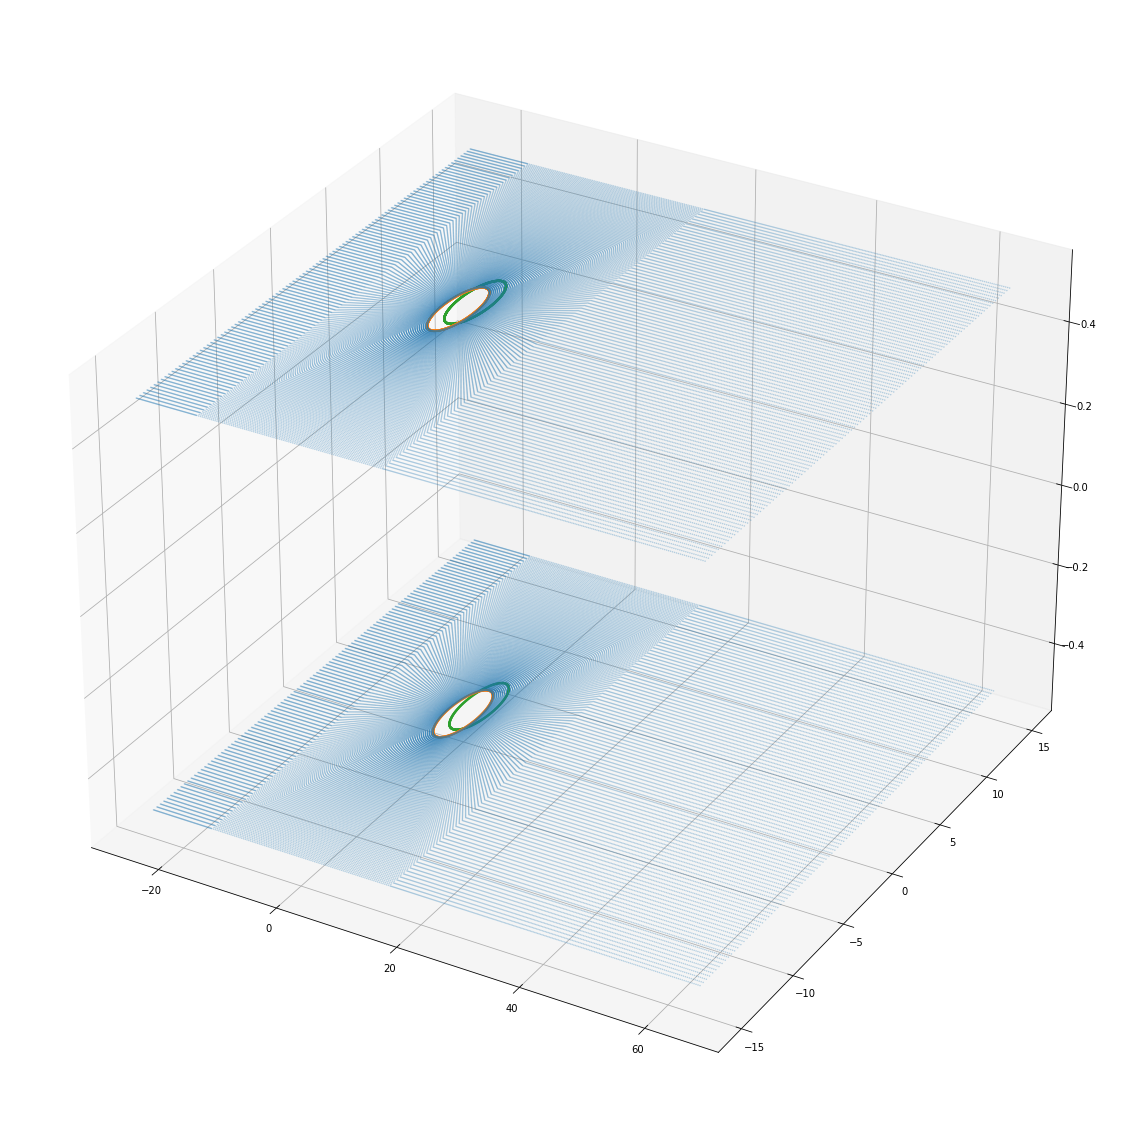

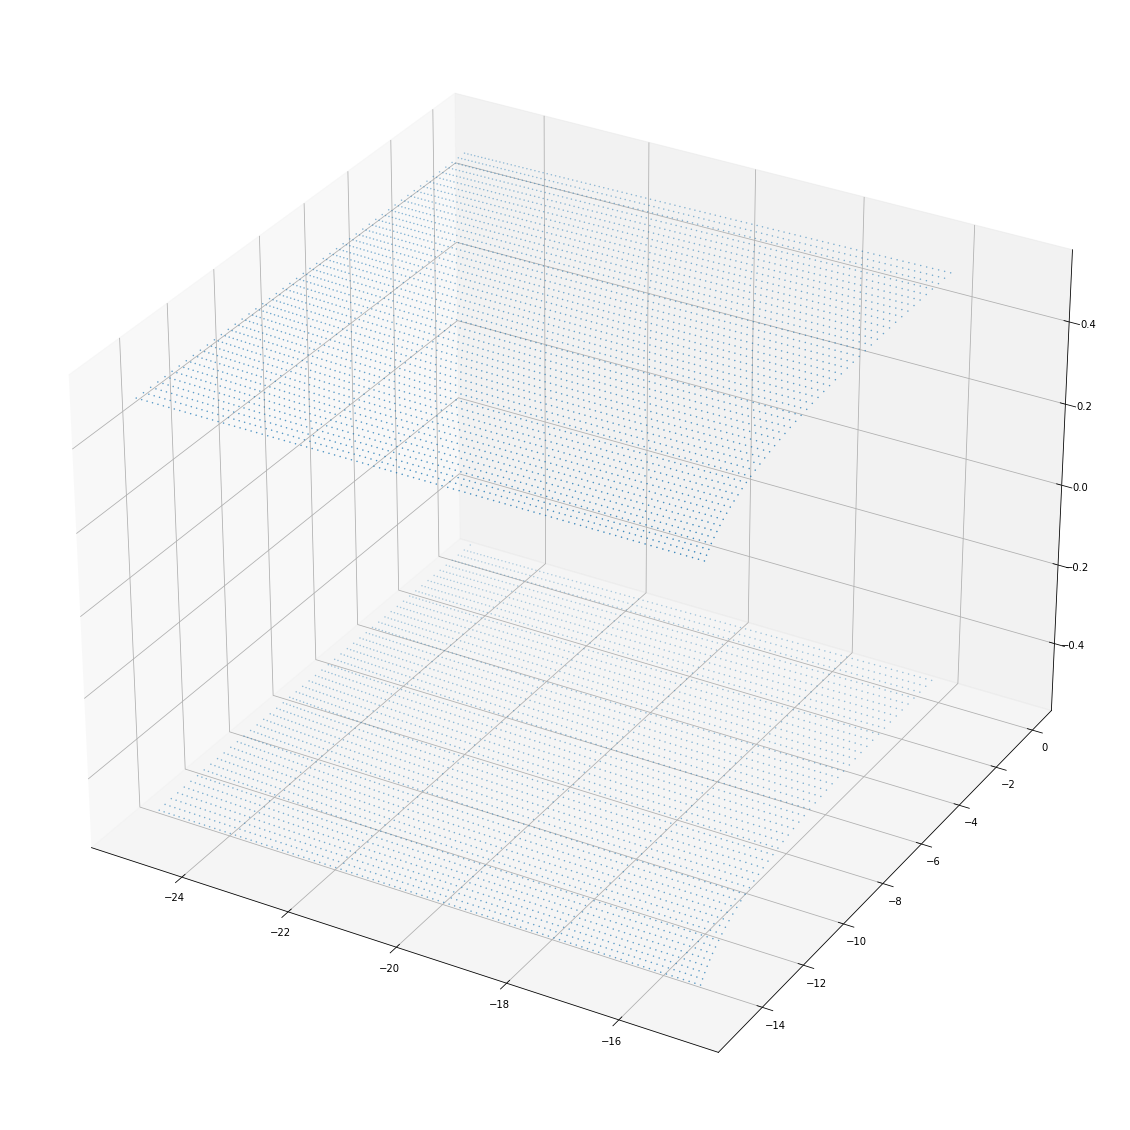

In [116]:
obstacle = extract_boundary_coords(mesh, b'obstacle')

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(projection='3d')
ax.scatter(*mesh.points.T, marker='.', s=1, alpha=0.3)
ax.scatter(*obstacle.T, s=2)
ax.scatter(*np.apply_along_axis(transform, 1, obstacle).T, s=2)
plt.show()

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(projection='3d')
new_mesh = interpolate_points(mesh.points[:10000], *train_interpolator(
                                    walls_coords(mesh), 
                                    obstacle, 
                                    obstacle + 1
                                )
                            )
ax.scatter(*new_mesh.T, marker='.', s=1)
plt.show()